<a href="https://colab.research.google.com/github/jojopapanana/techfest-bigdata/blob/main/TechFest_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import library
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# read data and make it dataframe in pyspark
spark = SparkSession.builder.getOrCreate()
gdp = spark.read.option("inferSchema", "true").csv("gdp.csv", header=True)
acebr = spark.read.option("inferSchema", "true").csv("annual-co-emissions-by-region.csv", header=True)

In [ ]:
# transpose data needed
gdp = gdp.drop('Unnamed: 65') # drop the unwanted column
gdp = gdp.toPandas() # change gdp to pandas dataframe inorder to use .melt() function
transposed_gdp = gdp.melt(id_vars=['Country Name', 'Code'], var_name='Year', value_name='GDP') \
                  .sort_values(['Country Name', 'Year']) \
                  .reset_index(drop=True)

# save the transposed data into dataframe in pyspark
spark_transposed_gdp = spark.createDataFrame(transposed_gdp)

In [ ]:
# data preprocessing or data cleaning
spark_transposed_gdp = spark_transposed_gdp.na.drop()
acebr = acebr.na.drop()

In [ ]:
# save data that will be used inside Temp Table
spark_transposed_gdp.registerTempTable("spark_transposed_gdp")
acebr.registerTempTable("acebr")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:330: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [ ]:
# cek data in table
spark_transposed_gdp.show(10)

+------------+----+----+------------------+
|Country Name|Code|Year|               GDP|
+------------+----+----+------------------+
| Afghanistan| AFG|1960|5.37777811111111E8|
| Afghanistan| AFG|1961|5.48888895555556E8|
| Afghanistan| AFG|1962|5.46666677777778E8|
| Afghanistan| AFG|1963|7.51111191111111E8|
| Afghanistan| AFG|1964|8.00000044444444E8|
| Afghanistan| AFG|1965|1.00666663777778E9|
| Afghanistan| AFG|1966|1.39999996666667E9|
| Afghanistan| AFG|1967|1.67333341777778E9|
| Afghanistan| AFG|1968|1.37333336666667E9|
| Afghanistan| AFG|1969|1.40888892222222E9|
+------------+----+----+------------------+
only showing top 10 rows



In [ ]:
# cek data in table
acebr.show(10)

+-----------+----+----+----------------------------------+
|     Entity|Code|Year|Annual CO2 emissions (zero filled)|
+-----------+----+----+----------------------------------+
|Afghanistan| AFG|1750|                                 0|
|Afghanistan| AFG|1751|                                 0|
|Afghanistan| AFG|1752|                                 0|
|Afghanistan| AFG|1753|                                 0|
|Afghanistan| AFG|1754|                                 0|
|Afghanistan| AFG|1755|                                 0|
|Afghanistan| AFG|1756|                                 0|
|Afghanistan| AFG|1757|                                 0|
|Afghanistan| AFG|1758|                                 0|
|Afghanistan| AFG|1759|                                 0|
+-----------+----+----+----------------------------------+
only showing top 10 rows



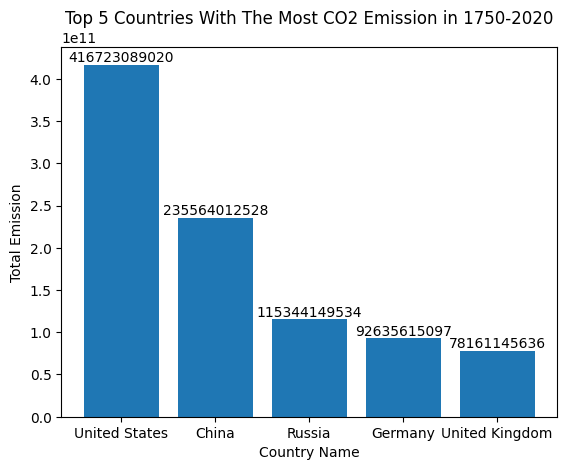

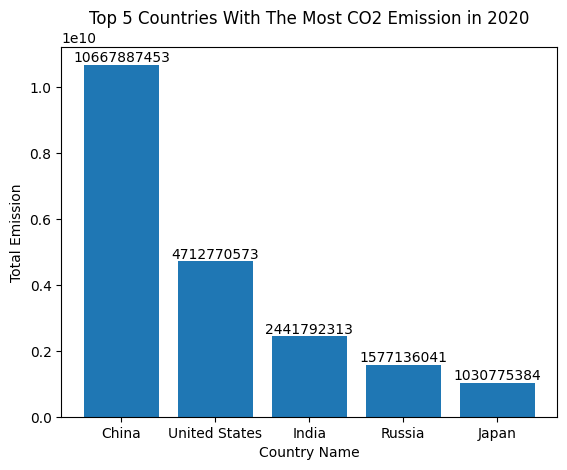

In [ ]:
# data visualisation

# query for all year range from 1750 - 2020
q1 = spark.sql("""SELECT Entity AS Country_Name, SUM(`Annual CO2 emissions (zero filled)`) AS Total_Emission
FROM acebr
WHERE Entity != "World"
GROUP BY Country_Name
ORDER BY Total_Emission DESC
LIMIT 5""")

# turn q1 into pandas dataframe to use matplotlib function
q1 = q1.toPandas()

# generate bar chart
plt.title("Top 5 Countries With The Most CO2 Emission in 1750-2020")
bars = plt.bar(q1["Country_Name"], q1["Total_Emission"])
plt.xlabel("Country Name")
plt.ylabel("Total Emission")

# show specific number in the center of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

# display the bar chart
plt.show()



# query for only the latest year (2020)
q1 = spark.sql("""SELECT Entity AS Country_Name, `Annual CO2 emissions (zero filled)` AS Total_Emission
FROM acebr
WHERE Entity != "World" AND Year = "2020"
ORDER BY Total_Emission DESC
LIMIT 5""")

# turn q1 into pandas dataframe to use matplotlib function
q1 = q1.toPandas()

# generate bar chart
plt.title("Top 5 Countries With The Most CO2 Emission in 2020")
bars = plt.bar(q1["Country_Name"], q1["Total_Emission"])
plt.xlabel("Country Name")
plt.ylabel("Total Emission")

# show specific number in the center of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

# display the bar chart
plt.show()

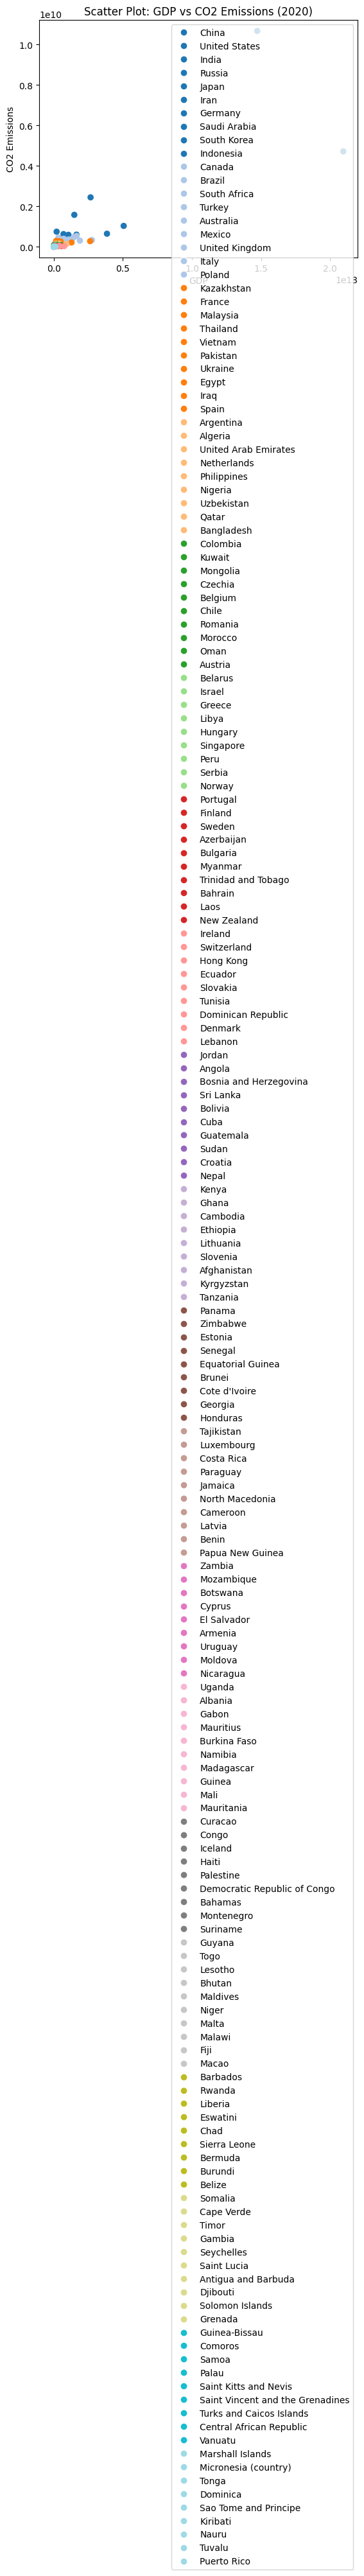

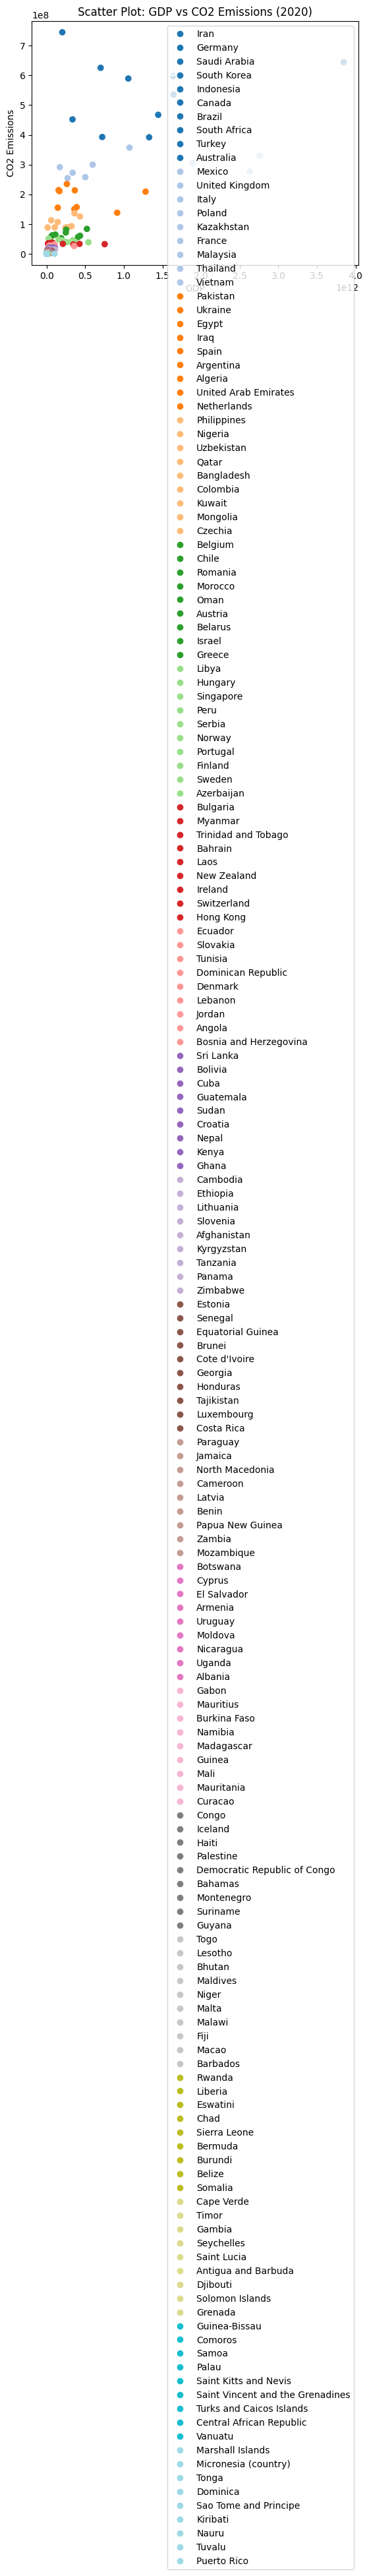

In [ ]:
# data visualization

# query for all existing country
q2 = spark.sql("""
    SELECT Entity, std.GDP, `Annual CO2 emissions (zero filled)` AS Emission, std.Year
    FROM spark_transposed_gdp std JOIN acebr ON std.Code = acebr.Code AND acebr.Year = std.Year
    WHERE std.Year = "2020"
    ORDER BY Emission DESC
""")

# turn q2 into pandas dataframe to use matplotlib function
q2 = q2.toPandas()

# create a dictionary to map unique Entity names to colors
entity_colors = {}
unique_entities = q2['Entity'].unique()
num_colors = len(unique_entities)
color_map = plt.get_cmap('tab20')
for i, entity in enumerate(unique_entities):
    entity_colors[entity] = color_map(i / num_colors)

# plot the scatter plot
plt.scatter(q2['GDP'], q2['Emission'], c=q2['Entity'].map(entity_colors))
plt.xlabel('GDP')
plt.ylabel('CO2 Emissions')
plt.title('Scatter Plot: GDP vs CO2 Emissions (2020)')

# create legend for Entity colors
legend_handles = []
for entity, color in entity_colors.items():
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=entity, markerfacecolor=color, markersize=8))

plt.legend(handles=legend_handles, loc='upper right')

# display the scatter plot
plt.show()



# query for all existing country excluding China, United States, India, Russia, and Japan which are the top 5 biggest emission contribution
q2 = spark.sql("""
    SELECT Entity, std.GDP, `Annual CO2 emissions (zero filled)` AS Emission, std.Year
    FROM spark_transposed_gdp std JOIN acebr ON std.Code = acebr.Code AND acebr.Year = std.Year
    WHERE std.Year = "2020" AND Entity NOT IN("China", "United States", "India", "Russia", "Japan")
    ORDER BY Emission DESC
""")

# turn q2 into pandas dataframe to use matplotlib function
q2 = q2.toPandas()

# create a dictionary to map unique Entity names to colors
entity_colors = {}
unique_entities = q2['Entity'].unique()
num_colors = len(unique_entities)
color_map = plt.get_cmap('tab20')
for i, entity in enumerate(unique_entities):
    entity_colors[entity] = color_map(i / num_colors)

# plot the scatter plot
plt.scatter(q2['GDP'], q2['Emission'], c=q2['Entity'].map(entity_colors))
plt.xlabel('GDP')
plt.ylabel('CO2 Emissions')
plt.title('Scatter Plot: GDP vs CO2 Emissions (2020)')

# create legend for Entity colors
legend_handles = []
for entity, color in entity_colors.items():
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=entity, markerfacecolor=color, markersize=8))

plt.legend(handles=legend_handles, loc='upper right')

# display the scatter plot
plt.show()


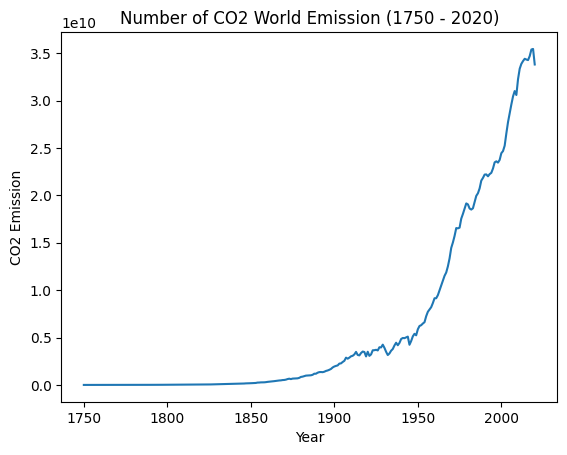

In [ ]:
# data visualization

q3 = spark.sql("""SELECT Year, SUM(`Annual CO2 emissions (zero filled)`) AS Emission
FROM acebr
WHERE Entity NOT IN("Low-income countries", "World", "Lower-middle-income countries", "Kuwaiti Oil Fires",
"High-income countries", "European Union (28)", "European Union (27)", "Europe (excl. EU-28)", "Europe (excl. EU-27)",
"Asia (excl. China & India)")
GROUP BY Year
ORDER BY Year ASC
""")

# turn q3 into pandas dataframe to use matplotlib function
q3 = q3.toPandas()

# generate line chart
plt.title("Number of CO2 World Emission (1750 - 2020)")
plt.plot(q3["Year"], q3["Emission"])
plt.xlabel("Year")
plt.ylabel("CO2 Emission")

# display line chart
plt.show()